## Imports

In [1]:
# pip install --upgrade scikit-learn

In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl
import pickle
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.2.0
Sklearn  0.24.0


## Get the dataset
- **CLOUD = True**: Download dataset from Kaggle. Necesary for cloud enviroments like COLAB. **Specify your [kaggle credentials](https://www.kaggle.com/docs/api)**.
- **CLOUD = False**: Get the dataset from your local machine. **Specify the data path**.

In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"
    os.environ['KAGGLE_KEY']      = "your_kaggle_api_key"  # See https://www.kaggle.com/docs/api
    !pip install --upgrade kaggle
    !kaggle competitions download -c titanic
    DATA_PATH = "./"

else:
    DATA_PATH = "../../datasets/titanic/"

## Load data

In [ ]:
df      = pd.read_csv("train.csv", index_col='PassengerId')
df_test = pd.read_csv("test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Check missings

In [6]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
df_test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

# Exercise 1:
Extract the title (Mr, Mrs, ... ) from the "Name" column.

Tips:
- split(',')[1] to get the 2nd part, and remove the surnamename
- split('.')[0] to get the 1str part, and remove the name

In [8]:
get_Title_from_Name = lambda x: x.split(',')[1].split('.')[0][1:]

In [9]:
# CODE HERE get_Title_from_Name funtion

df["Title"]      = df['Name'].map(get_Title_from_Name)
df_test["Title"] = df_test['Name'].map(get_Title_from_Name)

In [10]:
df['Title'].head()

PassengerId
1      Mr
2     Mrs
3    Miss
4     Mrs
5      Mr
Name: Title, dtype: object

In [11]:
df_test['Title'].head()

PassengerId
892     Mr
893    Mrs
894     Mr
895     Mr
896    Mrs
Name: Title, dtype: object

# Exercise 2:
Apply the title_dictionary to get a better information about the title. You have to overwrite the Title variable.

In [12]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [13]:
df_test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [14]:
df['Title'].value_counts()[:5]

Mr        517
Miss      182
Mrs       125
Master     40
Dr          7
Name: Title, dtype: int64

In [28]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    'Dona': 'Royalty'
}

In [29]:
df["Title"] = df['Title'].replace(title_dictionary)
df_test["Title"] = df_test["Title"].replace(title_dictionary)

In [30]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [31]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

In [32]:
df['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

# Exercise BONUS:
Try to extract some information from the feature **Ticket**

In [33]:
df['Ticket']

PassengerId
1             A/5 21171
2              PC 17599
3      STON/O2. 3101282
4                113803
5                373450
             ...       
887              211536
888              112053
889          W./C. 6607
890              111369
891              370376
Name: Ticket, Length: 891, dtype: object

# Exercise BONUS:
Try to extract some information from the feature **Cabin**

# Preprocessing
For X data:
- We drop Survived because is the target variable
- We drop Name because we have extracted the Title: Mr, Mrs, ...
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [34]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

In [35]:
cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age'] # x.select_dtypes(exclude=[object]).columns.values.tolist()

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

Categorical features:
 ['Sex', 'Embarked', 'Title']


# Exercise 3:
Create a **ColumnTransformer for Tree Models**. Remember:
- Categorical: Some SimpleImputer -> Some Encoder
- Numerical: Some SimpleImputer -> NO Encoder

In [68]:
%pip install sklearn-pandas

In [73]:
import sklearn_pandas

In [76]:
help(sklearn_pandas)

Help on package sklearn_pandas:

NAME
    sklearn_pandas

PACKAGE CONTENTS
    cross_validation
    dataframe_mapper
    features_generator
    pipeline
    transformers

DATA
    logger = <Logger sklearn_pandas (WARNING)>

VERSION
    2.0.4

FILE
    c:\users\amash\anaconda3\envs\strive\lib\site-packages\sklearn_pandas\__init__.py




In [79]:
help(sklearn_pandas.transformers)

Help on module sklearn_pandas.transformers in sklearn_pandas:

NAME
    sklearn_pandas.transformers

CLASSES
    sklearn.base.TransformerMixin(builtins.object)
        NumericalTransformer
    
    class NumericalTransformer(sklearn.base.TransformerMixin)
     |  NumericalTransformer(func)
     |  
     |  Provides commonly used numerical transformers.
     |  
     |  Method resolution order:
     |      NumericalTransformer
     |      sklearn.base.TransformerMixin
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, func)
     |      Params
     |      
     |      func    function to apply to input columns. The function will be
     |              applied to each value. Supported functions are defined
     |              in SUPPORTED_FUNCTIONS variable. Throws assertion error if the
     |              not supported.
     |  
     |  fit(self, X, y=None)
     |  
     |  transform(self, X, y=None)
     |  
     |  ----------------------

In [80]:
# Import necessary modules
from sklearn_pandas import DataFrameMapper
#from sklearn_pandas import CategoricalImputer

In [87]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [90]:
num_preprocessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
  ('imp', SimpleImputer()),
  ('scaler', StandardScaler())

])

cat_preporcessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
  ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
  # Some Encoder here. Remember to handle_unknown
  ('onehot', OneHotEncoder())
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['Sex', 'Embarked', 'Title'])])

In [91]:
x_prepro = tree_prepro.fit_transform(x)
x_test_prepro = tree_prepro.transform(x_test)

# Exercise 4
1. Complete the diccionary with some Tree Models.
2. Then we put each model in a Pipeline where:
   - first is the prepocessing with the column Transformer
   - Then is the Tree model
3. Display the fullpipeline of the LGBMClassifier

In [84]:
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

In [85]:
tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees": ExtraTreesClassifier(),
  "Random Forest": RandomForestClassifier(),
  "AdaBoost": AdaBoostClassifier(),
  "Skl GBM": GradientBoostingClassifier(),
  "Skl HistGBM": HistGradientBoostingClassifier(),
  "XGBoost": XGBClassifier(verbose=0),
  "LightGBM": LGBMClassifier(),
  "CatBoost": CatBoostClassifier(verbose=0)
}

tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

# Exercise 5:
Define a simple split validation strategy with:
- 80% for train
- 20% for validation
- With stratification
- random_state=0

And train all the models in a for loop

In [86]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    # CODE HERE
    x, y, test_size=0.2, stratify=y, random_state=0
)

for model_name, model in tree_classifiers.items():    
    # CODE HERE
    # TRAIN PIPELINE (PREPRO + MODEL) WITH TRAIN DATA
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    balanced_accuracy =  metrics.balanced_accuracy_score(y_val, y_pred)#*100
    # EVAL PIPELINE WITH VAL DATA (SEE ACCURACY AND BALANCED_ACCURACY)
    print(f'Accuracy of {model_name} is {model.score(x_val, y_val)}')
    print(f'Balanced Accuracy of {model_name} is {balanced_accuracy}')
    print()



Accuracy of Decision Tree is 0.7374301675977654
Balanced Accuracy of Decision Tree is 0.726943346508564

Accuracy of Extra Trees is 0.7597765363128491
Balanced Accuracy of Extra Trees is 0.737022397891963

Accuracy of Random Forest is 0.7653631284916201
Balanced Accuracy of Random Forest is 0.7415678524374176

Accuracy of AdaBoost is 0.7932960893854749
Balanced Accuracy of AdaBoost is 0.775098814229249

Accuracy of Skl GBM is 0.8379888268156425
Balanced Accuracy of Skl GBM is 0.8141633728590251

Accuracy of Skl HistGBM is 0.8156424581005587
Balanced Accuracy of Skl HistGBM is 0.7905797101449276

[02:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:45:24] W

# Exercise 6:
Define a 10 Fold cross validation strategy with:
- With stratification
- shuffle=True
- random_state=0

And train all the models in a for loop.

Tip you can use **[cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)** for both training and predict with 

In [62]:
skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True,random_state=0)

model_scores = {}
model_balanced_accuracy = {}

for model_name, model in tree_classifiers.items():
    # CODE HERE
    accuracy_scores = []
    balanced_accuracy_scores = []
    for train_index, val_index in skf.split(x,y):
        #print('Train:', train_index, 'Validation:', val_index)
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]


        # TRAIN PIPELINE (PREPRO + MODEL) WITH TRAIN DATA
        model.fit(x_train, y_train)
        
        # EVAL PIPELINE WITH VAL DATA (SEE ACCURACY AND BALANCED_ACCURACY)
        pred = model.predict(x_val)
        score = model.score(x_val, y_val)
        balanced_accuracy =  metrics.balanced_accuracy_score(y_val, pred)
        accuracy_scores.append(score)
        balanced_accuracy_scores.append(balanced_accuracy)
        
        #print(f'Accuracy of {model_name} is {score}')
        #print(f'Balanced Accuracy of {model_name} is {balanced_accuracy}')
        #print()
    model_scores[model_name] = accuracy_scores
    model_balanced_accuracy[model_name] = balanced_accuracy_scores
        



[23:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but sl

In [63]:
for model in model_scores:
    print(f'The mean accuracy score for {model} is {np.mean(model_scores[model])}')
    print(f'The mean balanced accuracy score for {model} is {np.mean(model_balanced_accuracy[model])}', end='\n\n')
    

The mean accuracy score for Decision Tree is 0.7855930087390761
The mean balanced accuracy score for Decision Tree is 0.778502956738251

The mean accuracy score for Extra Trees is 0.8047066167290886
The mean balanced accuracy score for Extra Trees is 0.7907315451433099

The mean accuracy score for Random Forest is 0.812609238451935
The mean balanced accuracy score for Random Forest is 0.7983106980165804

The mean accuracy score for AdaBoost is 0.811398252184769
The mean balanced accuracy score for AdaBoost is 0.7995467277820218

The mean accuracy score for Skl GBM is 0.8293632958801498
The mean balanced accuracy score for Skl GBM is 0.8104139433551198

The mean accuracy score for Skl HistGBM is 0.8248938826466917
The mean balanced accuracy score for Skl HistGBM is 0.8060395269218799

The mean accuracy score for XGBoost is 0.8204119850187265
The mean balanced accuracy score for XGBoost is 0.804011968423733

The mean accuracy score for LightGBM is 0.8215355805243446
The mean balanced acc

In [64]:
# sort accuracy and balanced accuracy scores in descending order
model_scores_sorted = sorted([(k, np.mean(v)) for k, v in model_scores.items()], reverse=True, key=lambda x: x[1])
model_balanced_accuracy_sorted = sorted([(k, np.mean(v)) for k, v in model_balanced_accuracy.items()], reverse=True, key=lambda x: x[1])

In [65]:
model_scores_sorted

[('CatBoost', 0.8338826466916354),
 ('Skl GBM', 0.8293632958801498),
 ('Skl HistGBM', 0.8248938826466917),
 ('LightGBM', 0.8215355805243446),
 ('XGBoost', 0.8204119850187265),
 ('Random Forest', 0.812609238451935),
 ('AdaBoost', 0.811398252184769),
 ('Extra Trees', 0.8047066167290886),
 ('Decision Tree', 0.7855930087390761)]

In [66]:
model_balanced_accuracy_sorted

[('CatBoost', 0.8123489799960387),
 ('Skl GBM', 0.8104139433551198),
 ('Skl HistGBM', 0.8060395269218799),
 ('LightGBM', 0.80555824349942),
 ('XGBoost', 0.804011968423733),
 ('AdaBoost', 0.7995467277820218),
 ('Random Forest', 0.7983106980165804),
 ('Extra Trees', 0.7907315451433099),
 ('Decision Tree', 0.778502956738251)]

In [148]:
(pd.DataFrame(model_balanced_accuracy_sorted, columns=['model', 'Score']).set_index('model').style.bar(subset=['Score'], vmin=0, vmax=1, color='blue'))

,Score
model,
CatBoost,0.812349
Skl GBM,0.810414
Skl HistGBM,0.806040
LightGBM,0.805558
XGBoost,0.804012
AdaBoost,0.799547
Random Forest,0.798311
Extra Trees,0.790732
Decision Tree,0.778503


# Exercise 7
Train **with all data** the best model

In [216]:
tree_classifiers.keys()

dict_keys(['Decision Tree', 'Extra Trees', 'Random Forest', 'AdaBoost', 'Skl GBM', 'Skl HistGBM', 'XGBoost', 'LightGBM', 'CatBoost'])

In [218]:
best_model = tree_classifiers['Skl GBM']

In [219]:
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [220]:
next_best_model = tree_classifiers['CatBoost']
next_best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000026E9D79BAC0>)])

In [221]:
best_model.fit(x, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [13]:
best_model = # Select your best model
# Train with all data your best model

In [222]:
next_best_model.fit(x,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000026E9D79BAC0>)])

In [223]:
test_pred2 = next_best_model.predict(x_test)

# Exercise 8
With your best model, generate the predicitions for test data (x_test)

In [23]:
test_pred = # Get the predictions for x_test

In [224]:
test_pred = best_model.predict(x_test)

# Exercise 9

Submit to kaggle using the kaggle API. And send us your score. You can try to improve it.

In [230]:
sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [231]:
sub2 = pd.DataFrame(test_pred2, index=x_test.index, columns=["Survived"])
sub2.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [238]:
sub.to_csv("sub.csv")

In [239]:
sub2.to_csv('sub2.csv')

In [ ]:
!kaggle competitions submit -c titanic -f sub.csv -m "My submission message"

# Exercise BONUS

Knowing how to export your models is very important for putting models in production. Try to
- Export and Load the ColumTransformer in pickle
- Export and Load the ColumTransformer in joblib
- Export and load the Pipeline

In [257]:
filename = 'skl_GBM_model.sav'
pickle.dump(best_model, open(filename, 'wb'))
 

 


In [258]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_val, y_val)
print(result)

0.8876404494382022


In [259]:
joblib_filename = 'catboost_model_joblib.sav'
joblib.dump(next_best_model, joblib_filename)
 


['catboost_model_joblib.sav']

In [260]:
# load the model from disk
catboost_loaded_model = joblib.load(joblib_filename)
result = catboost_loaded_model.score(x_val, y_val)
print(result)

0.8876404494382022


In [262]:
loaded_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [261]:
catboost_loaded_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000026E9E8E8F40>)])

In [263]:
tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp', SimpleImputer())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked', 'Title'])])

In [264]:
joblib.dump(next_best_model, 'tree_prepro.sav')


['tree_prepro.sav']

In [265]:
# load the model from disk
column_transformer_loaded = joblib.load('tree_prepro.sav')


In [266]:
column_transformer_loaded

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000026E9E91F1F0>)])

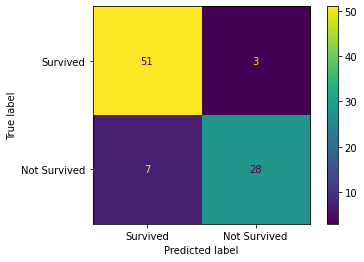

In [284]:
metrics.plot_confusion_matrix(best_model, x_val, y_val, display_labels=['Survived', 'Not Survived']);

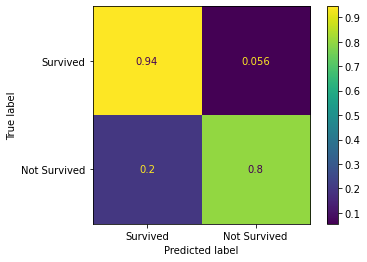

In [283]:
metrics.plot_confusion_matrix(best_model, x_val, y_val,
                       normalize="true", display_labels=['Survived', 'Not Survived']);